# Cocacola sales Forecasting

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt,ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")#,index_col='Month',parse_dates=True)

In [3]:
df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [4]:
df.tail()

,Quarter,Sales
37,Q2_95,4936.0
38,Q3_95,4895.0
39,Q4_95,4333.0
40,Q1_96,4194.0
41,Q2_96,5253.0


In [5]:
qs = df['Quarter'].str.replace(r'(Q\d)_(\d+)', r'19\2-\1')

In [6]:
df['date'] = pd.to_datetime(qs)

In [7]:
df.tail()

,Quarter,Sales,date
37,Q2_95,4936.0,1995-04-01
38,Q3_95,4895.0,1995-07-01
39,Q4_95,4333.0,1995-10-01
40,Q1_96,4194.0,1996-01-01
41,Q2_96,5253.0,1996-04-01


In [8]:
df.index = df.date

In [9]:
df.index.freq = 'QS'

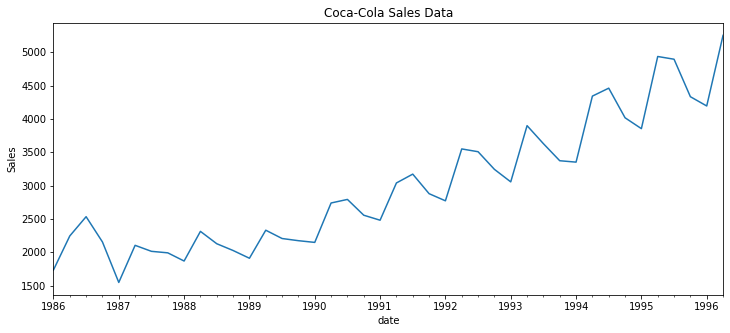

In [10]:
# Creating Line chart to visualize data.
title='Coca-Cola Sales Data'
ylabel='Sales'
ax = df['Sales'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=ylabel);

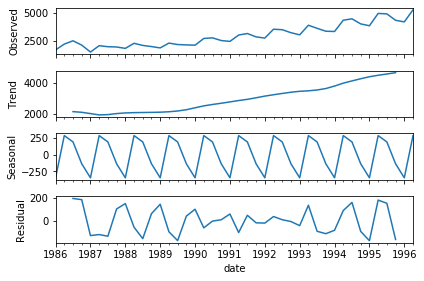

In [11]:
result = seasonal_decompose(df['Sales'], model='add')
result.plot();

We can see a linear trend and seasonality in data, when observed through ETS decomposition.

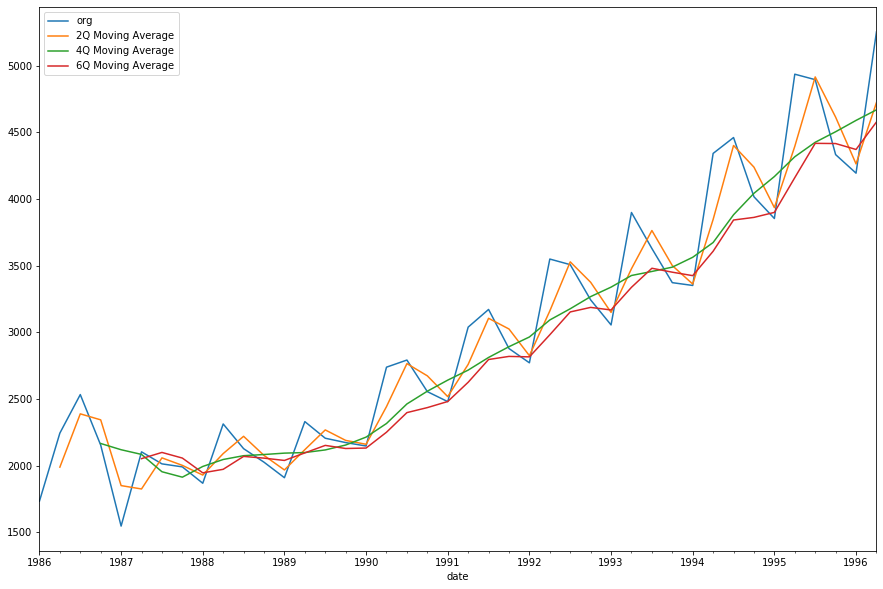

In [12]:
# moving average for the time series to understand better about the trend character in Airlines
import matplotlib.pyplot as plt
df.Sales.plot(label="org",figsize=(15,10))
for i in range(2,8,2):
    df["Sales"].rolling(i).mean().plot(label=str(i)+'Q Moving Average')
plt.legend(loc='upper left');

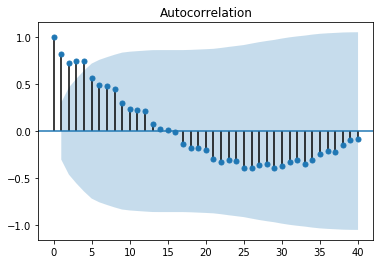

In [13]:
# ACF plots and PACF plots on Original data sets 
plot_acf(df.Sales,lags=40);

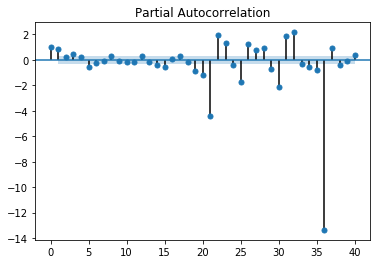

In [14]:
plot_pacf(df.Sales,lags=40);

Splitting the data into Train and Test data and considering the last 6 quarters data as Test data and left over data as train data

In [15]:
train = df[:len(df)-6]
test = df[len(df)-6:]

Lets try some model on Coca-Cola Sales data

In [16]:
#Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(train["Sales"]).fit()
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1]).rename("Pred_SES")
ses_rmse = rmse(pred_ses,test.Sales)
print(ses_rmse)

686.6815412784101


In [17]:
# Holt method 
hw_model = Holt(train["Sales"]).fit()
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1]).rename("hw_model")
hw_model_rmse = rmse(pred_hw,test.Sales)
print(hw_model_rmse)

497.5279170294985


In [18]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["Sales"],seasonal="add",trend="add",seasonal_periods=4,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1]).rename("hwe_model_add_add")
hwe_model_add_add_rmse = rmse(pred_hwe_add_add,test.Sales)
print(hwe_model_add_add_rmse)

198.37834597743185


In [19]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
hwe_model_mul_add_rmse = rmse(pred_hwe_mul_add,test.Sales)
print(hwe_model_mul_add_rmse)

181.42139710005108


In [20]:
# Lets us use auto_arima
auto_arima_model = auto_arima(train["Sales"],m=4,seasonal=True)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 4)   Log Likelihood                -202.255
Date:                           Tue, 22 Jun 2021   AIC                            412.510
Time:                                   13:30:18   BIC                            418.246
Sample:                                        0   HQIC                           414.380
                                            - 36                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.1820      7.196      1.276      0.202      -4.922      23.286
ar.L1          0.5526      0.303      1.827      0.068      -0.040       1.146
ma.L1         -0.9990     14.095     -0.071      0.943     -28.624      26.626
sigma2      2.543e+04   3.57e+05      0.071      0.943   -6.74e+05    7.25e+05
===================================================================================
Ljung-Box (Q):                       40.64   Jarque-Bera (JB):                 2.39
Prob(Q):                              0.09   Prob(JB):                         0.30
Heteroskedasticity (H):               0.71   Skew:                             0.40
Prob(H) (two-sided):                  0.59   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see a recommended ARIMA Order of (1,1,1) combined with a seasonal order of (0,1,0,4).

In [21]:
sarima_model = SARIMAX(train['Sales'],order=(1,1,1),seasonal_order=(0,1,0,4),enforce_stationarity=False).fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 4)   Log Likelihood                -190.135
Date:                           Tue, 22 Jun 2021   AIC                            386.270
Time:                                   13:30:18   BIC                            390.372
Sample:                               01-01-1986   HQIC                           387.555
                                    - 10-01-1994                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5121      0.385      1.330      0.184      -0.243       1.267
ma.L1         -0.7673      0.394     -1.949      0.051      -1.539       0.004
sigma2      2.934e+04   6194.646      4.736      0.000    1.72e+04    4.15e+04
===================================================================================
Ljung-Box (Q):                       52.22   Jarque-Bera (JB):                 5.83
Prob(Q):                              0.00   Prob(JB):                         0.05
Heteroskedasticity (H):               0.88   Skew:                             1.01
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
pred_sarima = sarima_model.predict(start = test.index[0],end = test.index[-1]).rename("sarima_model")
sarima_rmse = rmse(pred_sarima,test.Sales)
print(sarima_rmse)

174.75847336881128


In [23]:
model_review = pd.DataFrame(data=[ses_rmse,hw_model_rmse,hwe_model_add_add_rmse,hwe_model_mul_add_rmse,sarima_rmse],
                                  columns=["RMSE"],index=['ses_model','hw_model','hwe_model_add_add','hwe_model_mul_add','sarima_model'])

In [24]:
model_review

,RMSE
ses_model,686.681541
hw_model,497.527917
hwe_model_add_add,198.378346
hwe_model_mul_add,181.421397
sarima_model,174.758473


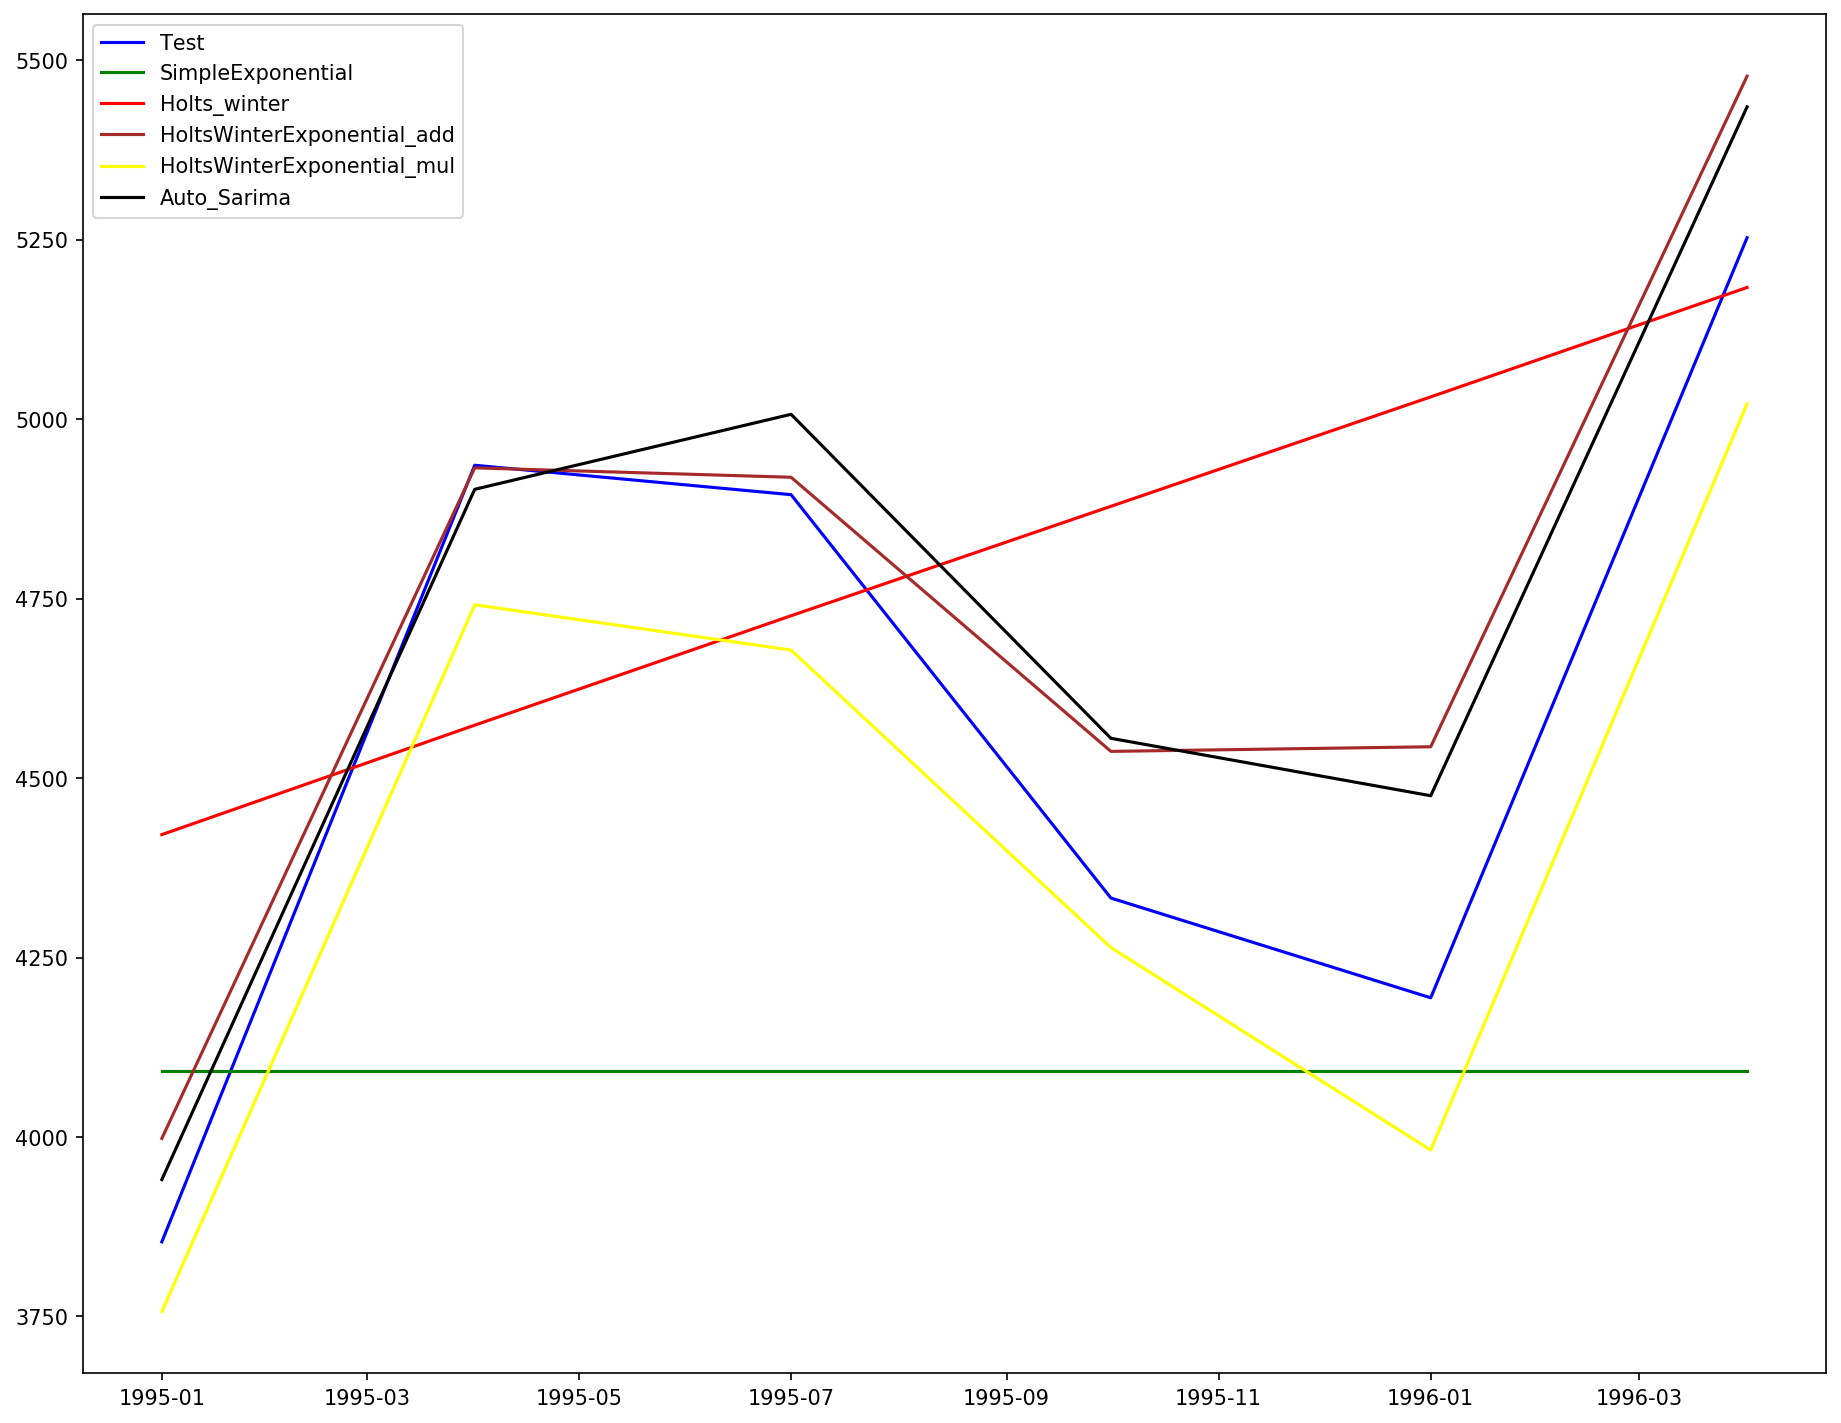

In [25]:
# Visualization of Forecasted values for Test data set using different methods 
plt.figure(figsize=(15,12),dpi=150)
plt.plot(test.index, test["Sales"], label='Test',color="blue")
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")
plt.plot(pred_hw.index, pred_hw, label='Holts_winter',color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_add",color="brown")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_mul",color="yellow")
plt.plot(pred_sarima.index,pred_sarima,label="Auto_Sarima",color="black")
plt.legend(loc='best');

By seeing above graph and rmse table we can choose Sarima Model as our model for forecasting.

## Retraining on Full Dataset

In [26]:
# Sarima model Order of (1,1,1) combined with a seasonal order of (0,1,0,4)
Final_model = ExponentialSmoothing(df.Sales,seasonal="add",trend="add",seasonal_periods=4,damped=True).fit()

In [27]:
fcast = Final_model.predict(len(df),len(df)+6).rename('Sarima model Order of (1,1,1)x(0,1,0,4) Forecast')

In [28]:
fcast

1996-07-01    5213.597330
1996-10-01    4673.627965
1997-01-01    4558.116221
1997-04-01    5656.927891
1997-07-01    5591.663109
1997-10-01    5051.693744
1998-01-01    4936.182000
Freq: QS-JAN, Name: Sarima model Order of (1,1,1)x(0,1,0,4) Forecast, dtype: float64

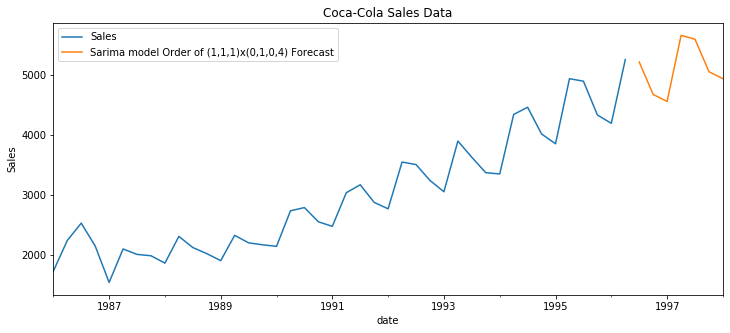

In [29]:
title='Coca-Cola Sales Data'
ylabel='Sales'
ax = df['Sales'].plot(figsize=(12,5),title=title,legend=True)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=ylabel);